# 16. 프로젝트 - Movielens 영화 SBR

## 목차

1. 데이터의 전처리
2. 미니 배치의 구성
3. 모델 구성
4. 모델 학습
5. 모델 테스트
6. 회고


## 루브릭

|평가문항|상세기준|
|:---|:---|
|1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.|데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.|
|2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.|적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.|
|3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.|3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.|

<p>이번에 우리는 <code>Movielens 1M Dataset</code>을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다. </p>

<p>우선 주요 라이브러리 버전을 확인해 보죠.</p>

In [258]:
import os
from pathlib import Path
import datetime as dt
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

warnings.filterwarnings('ignore')

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [259]:
data_path = Path(os.getenv('HOME')+'/aiffel/aiffel_project/exploration16/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [260]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


- 여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

### Step 1. 데이터의 전처리
<hr>
<p>위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.<br>특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.  </p>

유저수와 아이템 수

In [261]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [262]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [263]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [264]:
session_length.min(), session_length.max()

(20, 2314)

In [265]:
session_length.quantile(0.999)

1343.181000000005

In [266]:
long_session = session_length[session_length==200].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
406366,2438,908,3,2000-11-14 17:28:41
406379,2438,2294,3,2000-11-14 17:28:41
406412,2438,3812,5,2000-11-14 17:28:41
406418,2438,3835,2,2000-11-14 17:28:41
406427,2438,1186,4,2000-11-14 17:28:41
...,...,...,...,...
406356,2438,3948,4,2001-01-18 04:27:56
406461,2438,2502,4,2001-02-04 04:46:41
406372,2438,1466,4,2001-02-04 21:43:09
406413,2438,1131,5,2001-04-13 02:08:11


In [267]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

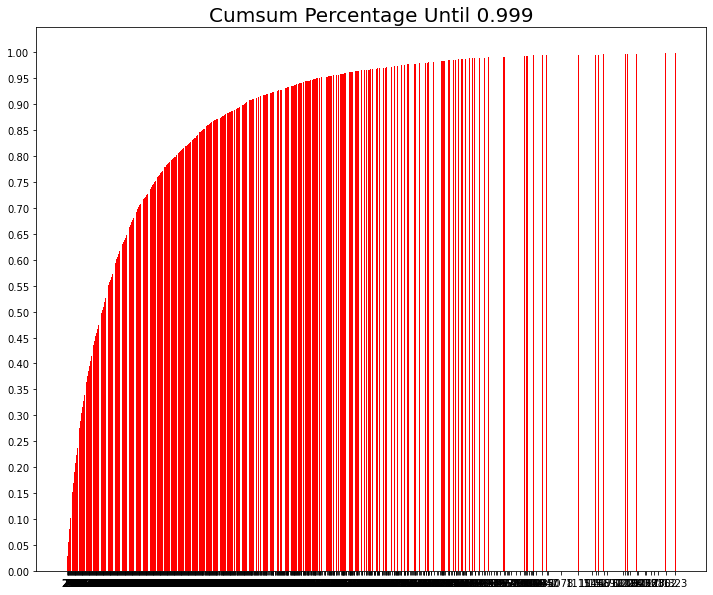

In [268]:
plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

<BarContainer object of 5 artists>

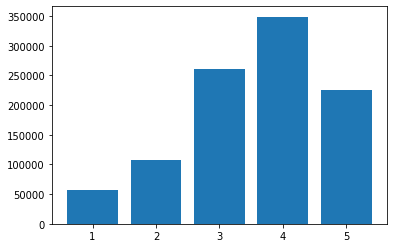

In [269]:
rating = data.groupby('Rating').size()
plt.bar(rating.index, data.groupby('Rating').size())

In [274]:
data = data[data['Rating'] > 2]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [275]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [348]:
month_ago = oldest + dt.timedelta(365)
data[data['Time'] <= month_ago]

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000188,6040,535,4,2000-07-28 23:58:54
1000191,6040,3751,4,2000-07-28 23:59:42
1000194,6040,1077,5,2000-07-28 23:59:59
999972,6040,3168,4,2000-07-29 00:01:40


In [351]:
month_ago = latest - dt.timedelta(365)
data = data[data['Time'] > month_ago]
data

,UserId,ItemId,Rating,Time
5170,36,1387,5,2002-03-12 03:46:59
5267,36,1201,4,2002-03-12 03:46:59
5122,36,1291,5,2002-03-12 03:47:16
5123,36,2167,5,2002-03-12 03:48:25
5290,36,2951,4,2002-03-12 03:48:25
...,...,...,...,...
992358,5996,3835,3,2002-04-29 20:46:24
992279,5996,2422,3,2002-04-29 20:47:05
992702,5996,168,3,2002-09-03 13:12:26
992459,5996,339,4,2002-10-07 13:24:39


- 2000년도 부터 1년 가까이 되는 데이터가 가장 많은 것을 볼 수 있다.
- 마지막 1년 데이터 값이 많이 없는 것을 알 수 있다.

In [352]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [353]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
5170,36,1387,5,2002-03-12 03:46:59
5267,36,1201,4,2002-03-12 03:46:59
5122,36,1291,5,2002-03-12 03:47:16
5123,36,2167,5,2002-03-12 03:48:25
5290,36,2951,4,2002-03-12 03:48:25
...,...,...,...,...
992553,5996,781,5,2002-04-29 20:18:44
992689,5996,2701,3,2002-04-29 20:26:16
992702,5996,168,3,2002-09-03 13:12:26
992459,5996,339,4,2002-10-07 13:24:39


### Step 2. 미니 배치의 구성
<hr>

실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [354]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [355]:
tr, test = split_by_date(data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

In [356]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [357]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 7709
	 Sessions: 283
	 Items: 1238
	 First Time : 2002-02-28 19:06:39
	 Last Time : 2002-12-30 02:26:14

* valid Set Stats Info
	 Events: 2333
	 Sessions: 81
	 Items: 986
	 First Time : 2002-02-28 23:32:05
	 Last Time : 2003-01-29 03:00:40

* test Set Stats Info
	 Events: 4416
	 Sessions: 90
	 Items: 1203
	 First Time : 2002-03-01 04:03:30
	 Last Time : 2003-02-28 17:49:08



In [358]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [359]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [360]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [361]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,2002-03-12 03:46:59,0
5267,36,1201,4,2002-03-12 03:46:59,1
5122,36,1291,5,2002-03-12 03:47:16,2
5123,36,2167,5,2002-03-12 03:48:25,3
5290,36,2951,4,2002-03-12 03:48:25,4
5359,36,2115,5,2002-03-12 03:48:25,5
5073,36,1912,5,2002-03-12 03:48:44,6
5113,36,2662,3,2002-03-12 03:48:44,7
5366,36,2985,4,2002-03-12 03:49:01,8
5145,36,198,5,2002-03-12 03:49:48,9


In [362]:
tr_dataset.click_offsets

array([   0,   29,   35,   43,   48,   50,   71,   77,   94,  105,  149,
        212,  224,  296,  328,  348,  356,  364,  368,  371,  399,  409,
        414,  433,  481,  495,  507,  509,  554,  560,  564,  566,  670,
        676,  682,  715,  723,  730,  769,  771,  778,  780,  782,  795,
        797,  823,  826,  833,  842,  870,  973,  979, 1092, 1097, 1100,
       1104, 1478, 1495, 1526, 1539, 1541, 1564, 1567, 1573, 1578, 1586,
       1589, 1627, 1630, 1661, 1686, 1714, 1806, 1835, 1844, 1878, 1968,
       1970, 1980, 1995, 2048, 2058, 2112, 2131, 2142, 2147, 2321, 2337,
       2347, 2398, 2411, 2506, 2584, 2614, 2630, 2657, 2682, 2733, 2749,
       2753, 2770, 2775, 2787, 2806, 2808, 2818, 2824, 2833, 2881, 2884,
       2942, 2954, 2973, 2975, 2988, 2990, 3003, 3024, 3107, 3111, 3142,
       3152, 3167, 3195, 3205, 3255, 3274, 3318, 3323, 3428, 3484, 3489,
       3553, 3556, 3561, 3569, 3575, 3581, 3587, 3606, 3609, 3630, 3759,
       3761, 3815, 3878, 3882, 3947, 3962, 4081, 41

In [363]:
tr_dataset.session_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [364]:
len(tr_dataset.click_offsets), len(tr_dataset.session_idx)

(284, 283)

In [365]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        if len(first_iters) > len(self.dataset.click_offsets):
            first_iters = np.arange(len(self.dataset.click_offsets))
            last_session = len(self.dataset.click_offsets)
       
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [366]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,2002-03-12 03:46:59,0
5267,36,1201,4,2002-03-12 03:46:59,1
5122,36,1291,5,2002-03-12 03:47:16,2
5123,36,2167,5,2002-03-12 03:48:25,3
5290,36,2951,4,2002-03-12 03:48:25,4
...,...,...,...,...,...
992553,5996,781,5,2002-04-29 20:18:44,969
992689,5996,2701,3,2002-04-29 20:26:16,931
992702,5996,168,3,2002-09-03 13:12:26,1036
992459,5996,339,4,2002-10-07 13:24:39,581


In [367]:
iter_ex = iter(tr_data_loader)

In [368]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 29 35 43]
Label Item Idx are :       [ 1 30 36 44]
Previous Masked Input Idx are []


### Step 3. 모델 구성
<hr>
이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

In [293]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [294]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [295]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=8, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [223]:
model = create_model(args)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(8, 1, 3416)]            0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        520200    
_________________________________________________________________
dropout_9 (Dropout)          (8, 50)                   0         
_________________________________________________________________
dense_9 (Dense)              (8, 3416)                 174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


### Step 4. 모델 학습
<hr>
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [224]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [225]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)


Evaluation:  93%|█████████▎| 3427/3674 [03:25<00:14, 16.70it/s]


	 - Recall@20 epoch 1: 0.209914
	 - MRR@20    epoch 1: 0.057002



Evaluation:  93%|█████████▎| 3427/3674 [03:24<00:14, 16.79it/s]


	 - Recall@20 epoch 2: 0.223300
	 - MRR@20    epoch 2: 0.062662



Evaluation:  93%|█████████▎| 3427/3674 [03:23<00:14, 16.82it/s]

	 - Recall@20 epoch 3: 0.226145
	 - MRR@20    epoch 3: 0.063678



### Step 5. 모델 테스트
<hr>
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [226]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  96%|█████████▌| 6095/6352 [06:05<00:15, 16.68it/s]

	 - Recall@20: 0.211587
	 - MRR@20: 0.060172



## 성능 향상을 위한 시도

### 2회차

In [227]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.01, epochs=3, k=20)
model = create_model(args)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(64, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      520200    
_________________________________________________________________
dropout_10 (Dropout)         (64, 50)                  0         
_________________________________________________________________
dense_10 (Dense)             (64, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [228]:
train_model(model, args)

Evaluation:  29%|██▊       | 131/459 [00:36<01:31,  3.60it/s]


	 - Recall@20 epoch 1: 0.250358
	 - MRR@20    epoch 1: 0.065759



Evaluation:  29%|██▊       | 131/459 [00:35<01:29,  3.67it/s]


	 - Recall@20 epoch 2: 0.251312
	 - MRR@20    epoch 2: 0.068219



Evaluation:  29%|██▊       | 131/459 [00:35<01:28,  3.70it/s]

	 - Recall@20 epoch 3: 0.260138
	 - MRR@20    epoch 3: 0.070548



In [229]:
test_model(model, args, test)

Evaluation:  53%|█████▎    | 418/794 [01:54<01:43,  3.65it/s]

	 - Recall@20: 0.242001
	 - MRR@20: 0.065861



### 3회차

In [296]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.01, epochs=3, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      503850    
_________________________________________________________________
dropout_11 (Dropout)         (64, 50)                  0         
_________________________________________________________________
dense_11 (Dense)             (64, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


Evaluation:  33%|███▎      | 128/391 [00:35<01:13,  3.60it/s]


	 - Recall@20 epoch 1: 0.248169
	 - MRR@20    epoch 1: 0.067722



Evaluation:  33%|███▎      | 128/391 [00:34<01:11,  3.68it/s]


	 - Recall@20 epoch 2: 0.253784
	 - MRR@20    epoch 2: 0.067775



Evaluation:  33%|███▎      | 128/391 [00:34<01:11,  3.68it/s]

	 - Recall@20 epoch 3: 0.250854
	 - MRR@20    epoch 3: 0.066983



In [297]:
test_model(model, args, test)

Evaluation:  51%|█████     | 325/641 [01:28<01:26,  3.67it/s]

	 - Recall@20: 0.243317
	 - MRR@20: 0.063384



### 4회차

In [332]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.01, epochs=10, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      503850    
_________________________________________________________________
dropout_23 (Dropout)         (64, 50)                  0         
_________________________________________________________________
dense_23 (Dense)             (64, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


Evaluation:  33%|███▎      | 128/391 [00:34<01:11,  3.67it/s]


	 - Recall@20 epoch 1: 0.249756
	 - MRR@20    epoch 1: 0.067251



Evaluation:  33%|███▎      | 128/391 [00:34<01:10,  3.74it/s]


	 - Recall@20 epoch 2: 0.259644
	 - MRR@20    epoch 2: 0.069629



Evaluation:  33%|███▎      | 128/391 [00:35<01:12,  3.63it/s]


	 - Recall@20 epoch 3: 0.255371
	 - MRR@20    epoch 3: 0.069394



Evaluation:  33%|███▎      | 128/391 [00:35<01:11,  3.65it/s]


	 - Recall@20 epoch 4: 0.252075
	 - MRR@20    epoch 4: 0.069103



Evaluation:  33%|███▎      | 128/391 [00:35<01:12,  3.65it/s]


	 - Recall@20 epoch 5: 0.252930
	 - MRR@20    epoch 5: 0.068332



Evaluation:  33%|███▎      | 128/391 [00:34<01:11,  3.66it/s]


	 - Recall@20 epoch 6: 0.253662
	 - MRR@20    epoch 6: 0.068395



Evaluation:  33%|███▎      | 128/391 [00:34<01:11,  3.66it/s]


	 - Recall@20 epoch 7: 0.255127
	 - MRR@20    epoch 7: 0.068855



Evaluation:  33%|███▎      | 128/391 [00:34<01:11,  3.70it/s]


	 - Recall@20 epoch 8: 0.252563
	 - MRR@20    epoch 8: 0.068543



Evaluation:  33%|███▎      | 128/391 [00:34<01:11,  3.70it/s]


	 - Recall@20 epoch 9: 0.254272
	 - MRR@20    epoch 9: 0.070784



Evaluation:  33%|███▎      | 128/391 [00:34<01:10,  3.73it/s]

	 - Recall@20 epoch 10: 0.258301
	 - MRR@20    epoch 10: 0.071416



In [333]:
test_model(model, args, test)

Evaluation:  51%|█████     | 325/641 [01:29<01:27,  3.63it/s]

	 - Recall@20: 0.242500
	 - MRR@20: 0.064775



### 5회차

In [334]:
args = Args(tr, val, test, batch_size=64, hsz=20, drop_rate=0.1, lr=0.01, epochs=3, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 20), (64, 20)]      199740    
_________________________________________________________________
dropout_24 (Dropout)         (64, 20)                  0         
_________________________________________________________________
dense_24 (Dense)             (64, 3307)                69447     
Total params: 269,187
Trainable params: 269,187
Non-trainable params: 0
_________________________________________________________________


Evaluation:  33%|███▎      | 128/391 [00:35<01:12,  3.64it/s]


	 - Recall@20 epoch 1: 0.247192
	 - MRR@20    epoch 1: 0.062978



Evaluation:  33%|███▎      | 128/391 [00:35<01:12,  3.62it/s]


	 - Recall@20 epoch 2: 0.252930
	 - MRR@20    epoch 2: 0.064501



Evaluation:  33%|███▎      | 128/391 [00:35<01:11,  3.66it/s]

	 - Recall@20 epoch 3: 0.253418
	 - MRR@20    epoch 3: 0.065029



In [335]:
test_model(model, args, test)

Evaluation:  51%|█████     | 325/641 [01:28<01:26,  3.65it/s]

	 - Recall@20: 0.237788
	 - MRR@20: 0.062263



### 6회차

In [339]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.3, lr=0.001, epochs=10, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      503850    
_________________________________________________________________
dropout_26 (Dropout)         (64, 50)                  0         
_________________________________________________________________
dense_26 (Dense)             (64, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


Evaluation:  33%|███▎      | 128/391 [00:35<01:13,  3.57it/s]


	 - Recall@20 epoch 1: 0.240356
	 - MRR@20    epoch 1: 0.062315



Evaluation:  33%|███▎      | 128/391 [00:34<01:11,  3.68it/s]


	 - Recall@20 epoch 2: 0.276367
	 - MRR@20    epoch 2: 0.074074



Evaluation:  33%|███▎      | 128/391 [00:34<01:10,  3.76it/s]


	 - Recall@20 epoch 3: 0.292725
	 - MRR@20    epoch 3: 0.079730



Evaluation:  33%|███▎      | 128/391 [00:33<01:09,  3.78it/s]


	 - Recall@20 epoch 4: 0.300293
	 - MRR@20    epoch 4: 0.082242



Evaluation:  33%|███▎      | 128/391 [00:33<01:09,  3.79it/s]


	 - Recall@20 epoch 5: 0.301270
	 - MRR@20    epoch 5: 0.085733



Evaluation:  33%|███▎      | 128/391 [00:33<01:08,  3.84it/s]


	 - Recall@20 epoch 6: 0.305542
	 - MRR@20    epoch 6: 0.087127



Evaluation:  33%|███▎      | 128/391 [00:33<01:08,  3.84it/s]


	 - Recall@20 epoch 7: 0.306152
	 - MRR@20    epoch 7: 0.087873



Evaluation:  33%|███▎      | 128/391 [00:33<01:08,  3.83it/s]


	 - Recall@20 epoch 8: 0.305420
	 - MRR@20    epoch 8: 0.089819



Evaluation:  33%|███▎      | 128/391 [00:33<01:09,  3.78it/s]


	 - Recall@20 epoch 9: 0.306396
	 - MRR@20    epoch 9: 0.090371



Evaluation:  33%|███▎      | 128/391 [00:33<01:09,  3.81it/s]

	 - Recall@20 epoch 10: 0.306396
	 - MRR@20    epoch 10: 0.091098



In [340]:
test_model(model, args, test)

Evaluation:  51%|█████     | 325/641 [01:28<01:25,  3.68it/s]

	 - Recall@20: 0.295000
	 - MRR@20: 0.087046



### 7회차

In [341]:
args = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.3, lr=0.001, epochs=10, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    1022700   
_________________________________________________________________
dropout_27 (Dropout)         (64, 100)                 0         
_________________________________________________________________
dense_27 (Dense)             (64, 3307)                334007    
Total params: 1,356,707
Trainable params: 1,356,707
Non-trainable params: 0
_________________________________________________________________


Evaluation:  33%|███▎      | 128/391 [00:34<01:11,  3.66it/s]


	 - Recall@20 epoch 1: 0.258911
	 - MRR@20    epoch 1: 0.069871



Evaluation:  33%|███▎      | 128/391 [00:34<01:10,  3.71it/s]


	 - Recall@20 epoch 2: 0.286255
	 - MRR@20    epoch 2: 0.079948



Evaluation:  33%|███▎      | 128/391 [00:33<01:09,  3.79it/s]


	 - Recall@20 epoch 3: 0.301270
	 - MRR@20    epoch 3: 0.086978



Evaluation:  33%|███▎      | 128/391 [00:33<01:08,  3.84it/s]


	 - Recall@20 epoch 4: 0.306763
	 - MRR@20    epoch 4: 0.089629



Evaluation:  33%|███▎      | 128/391 [00:33<01:08,  3.84it/s]


	 - Recall@20 epoch 5: 0.310059
	 - MRR@20    epoch 5: 0.092976



Evaluation:  33%|███▎      | 128/391 [00:34<01:11,  3.70it/s]


	 - Recall@20 epoch 6: 0.313721
	 - MRR@20    epoch 6: 0.094080



Evaluation:  33%|███▎      | 128/391 [00:34<01:10,  3.74it/s]


	 - Recall@20 epoch 7: 0.315552
	 - MRR@20    epoch 7: 0.094004



Evaluation:  33%|███▎      | 128/391 [00:33<01:09,  3.78it/s]


	 - Recall@20 epoch 8: 0.314819
	 - MRR@20    epoch 8: 0.094891



Evaluation:  33%|███▎      | 128/391 [00:33<01:08,  3.85it/s]


	 - Recall@20 epoch 9: 0.315796
	 - MRR@20    epoch 9: 0.094940



Evaluation:  33%|███▎      | 128/391 [00:33<01:08,  3.85it/s]

	 - Recall@20 epoch 10: 0.317505
	 - MRR@20    epoch 10: 0.095398



In [342]:
test_model(model, args, test)

Evaluation:  51%|█████     | 325/641 [01:26<01:24,  3.75it/s]

	 - Recall@20: 0.303606
	 - MRR@20: 0.089970



### 8회차

In [369]:
args = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.3, lr=0.001, epochs=10, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(64, 1, 1238)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    402000    
_________________________________________________________________
dropout_28 (Dropout)         (64, 100)                 0         
_________________________________________________________________
dense_28 (Dense)             (64, 1238)                125038    
Total params: 527,038
Trainable params: 527,038
Non-trainable params: 0
_________________________________________________________________


Evaluation:  20%|██        | 7/35 [00:02<00:09,  2.96it/s]


	 - Recall@20 epoch 1: 0.058036
	 - MRR@20    epoch 1: 0.009926



Evaluation:  20%|██        | 7/35 [00:02<00:08,  3.13it/s]


	 - Recall@20 epoch 2: 0.060268
	 - MRR@20    epoch 2: 0.009515



Evaluation:  20%|██        | 7/35 [00:02<00:08,  3.18it/s]


	 - Recall@20 epoch 3: 0.064732
	 - MRR@20    epoch 3: 0.011315



Evaluation:  20%|██        | 7/35 [00:02<00:08,  3.15it/s]


	 - Recall@20 epoch 4: 0.066964
	 - MRR@20    epoch 4: 0.011866



Evaluation:  20%|██        | 7/35 [00:02<00:08,  3.28it/s]


	 - Recall@20 epoch 5: 0.073661
	 - MRR@20    epoch 5: 0.012161



Evaluation:  20%|██        | 7/35 [00:02<00:08,  3.22it/s]


	 - Recall@20 epoch 6: 0.069196
	 - MRR@20    epoch 6: 0.012614



Evaluation:  20%|██        | 7/35 [00:02<00:08,  3.27it/s]


	 - Recall@20 epoch 7: 0.071429
	 - MRR@20    epoch 7: 0.013591



Evaluation:  20%|██        | 7/35 [00:02<00:08,  3.27it/s]


	 - Recall@20 epoch 8: 0.078125
	 - MRR@20    epoch 8: 0.013851



Evaluation:  20%|██        | 7/35 [00:02<00:08,  3.27it/s]


	 - Recall@20 epoch 9: 0.082589
	 - MRR@20    epoch 9: 0.017049



Evaluation:  20%|██        | 7/35 [00:02<00:08,  3.26it/s]

	 - Recall@20 epoch 10: 0.075893
	 - MRR@20    epoch 10: 0.018390



In [370]:
test_model(model, args, test)

Evaluation:  28%|██▊       | 19/67 [00:05<00:15,  3.18it/s]

	 - Recall@20: 0.047697
	 - MRR@20: 0.009256



## 결과

||batch_size|hsz|drop_rate|lr|epochs|전처리|훈련|테스트|
|:---|:---|:---|:---|:---|:---|:---|:---|:---|
|1|8|50|0.1|0.01|3|없음|Recall@20: 0.260138, MRR@20: 0.070548|Recall@20: 0.211587, MRR@20: 0.060172 |
|2|64|50|0.1|0.1|3|없음|Recall@20: 0.260138, MRR@20: 0.070548|Recall@20: 0.242001, MRR@20: 0.065861 |
|3|64|50|0.1|0.01|3|rating 2이하 삭제|Recall@20: 0.250854, MRR@20: 0.066983|Recall@20: 0.243317, MRR@20: 0.063384|
|4|64|50|0.1|0.01|10|rating 2이하 삭제|Recall@20: 0.258301, MRR@20: 0.071416|Recall@20: 0.242500, MRR@20: 0.064775|
|5|64|20|0.1|0.01|3|rating 2이하 삭제|Recall@20: 0.253418, MRR@20: 0.065029|Recall@20: 0.237788, MRR@20: 0.062263|
|6|64|50|0.3|0.001|10|rating 2이하 삭제|Recall@20: 0.306396, MRR@20: 0.091098|Recall@20: 0.295000, MRR@20:0.087046|
|7|64|100|0.3|0.001|10|rating 2이하 삭제|Recall@20: 0.317505, MRR@20: 0.095398|Recall@20: 0.303606, MRR@20:0.089970|
|8|64|100|0.3|0.001|10|rating 2이하 삭제, 날짜 마지막으로 부터 1년 데이터 사용|Recall@20: 0.075893, MRR@20: 0.018390|Recall@20: 0.047697, MRR@20:0.009256|

- 가장 좋은 결과가 나온것은 6, 7회입니다.
- 6, 7회의 경우 epochs를 더 늘리면 성능향상이 가능할 것으로 보입니다.
- accuracy, train_loss 값은 변동이 거의 없었습니다.
- 좋은 결과를 도출하고 싶다면 더 많은 양의 학습이 필요한 것 같습니다.
- 8회의 경우 오히려 데이터가 적어서 결과가 더 안 좋은 것 같습니다.

## 회고

- 처음 학습 시 오류가 발생했습니다.
    - 이 오류는 배치 사이즈와 관련이 있었는데 SessionDataLoader 의 initialize의 start와 end를 만드는 과정에서 배치 사이즈를 이용하여 세션을 가져오는데 리스트보다 배치 사이즈 크기가 커서 오류가 발생하였습니다.
    - 오류 해결을 위해서 if 문을 통해 리스트 크기보다 배치 사이즈가 클 경우 배치 사이즈를 사용하는 것이 아닌 리스트 크기를 사용할 수 있도록 했습니다.
    - 이 방법으로도 배치 사이즈 64까지 키울 수 있었습니다. 하지만 128로 배치 사이즈를 크기를 증가시킬 경우 여기서도 오류가 발생하는데 그 이유는 모르겠습니다.
- 날짜 데이터 변환에 관해 공부할 수 있는 좋은 기회였던 것 같습니다.